In [17]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
from torchsummary import summary
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset

# library to get dataloader
from dataloaders import get_pkmn_dataloader,get_denormalization_transform

# library to get loss functions
from loss_functions import get_generator_loss_func,get_disc_loss_func,gradient_penalty,get_gradient

# generators and discriminators
from DCGeneratorCustom import DCGeneratorCustom
from DCDiscriminatorCustom import DCDiscriminatorCustom
from DCGeneratorStandard import DCGeneratorStandard
from DCDiscriminatorStandard import DCDiscriminatorStandard
from DCDiscriminatorStandardDropout import DCDiscriminatorStandardDropout
from DiscriminatorPatchGAN import DiscriminatorPatchGAN

from DCGeneratorConditional import DCGeneratorConditional
from DCDiscriminatorConditional import DCDiscriminatorConditional
from UNetArchitecture import UNet


# for classification analysis
from MultiClassConvNetStandardDropout import MultiClassConvNetStandardDropout

# util methods
from utils import get_noise

# constants
from pkmn_constants import PKMN_TYPES,CLASS_IDX_2_PKMN_TYPE,NUM_PKMN_TYPES

# whether to use CPU/GPU (pass this along everywhere)
device_str = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_str)

print("Using device: {}".format(device_str))

Using device: cpu


In [6]:
print(torch.__version__)

# if apply_denormalization is true, then we re-scale the images back 
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), denorm_transform = None, use_uniform_transform = False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    
    # We don't specifically need this since we are doing the denormalization ourself
    
    if denorm_transform is not None:
      assert use_uniform_transform == False
      image_tensor = denorm_transform(image_tensor)
    if use_uniform_transform:
      # cannot use both uniform and denorm transform together
      assert denorm_transform == None
      image_tensor = (image_tensor + 1) / 2 # scale from [-1, 1] to [0, 1] space
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def save_model(model, output_filename):
  torch.save(model.state_dict(), output_filename)

1.10.2


In [18]:
# ==== Define the dataloader ===

jpg_directory = "./pokemon_images_size=64_shiny=False__bg=WHITE_mainclass=True_groupclasses=True" 

# Convert channels from [0, 1] to [-1, 1]
channel_means, channel_stds = (0.5, 0.5, 0.5), (0.5,0.5,0.5)

normal_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean = channel_means, std = channel_stds)
])

# use random flip and normalization transform
flip_transforms = transforms.Compose([
  transforms.RandomHorizontalFlip(p=1.0),
  transforms.ToTensor(),
  transforms.Normalize(mean = channel_means, std = channel_stds)
])

# use random flip and normalization transform
rotate_transforms = transforms.Compose([
  transforms.RandomRotation(45), # rotate up to 45 degrees in each direction
  transforms.ToTensor(),
  transforms.Normalize(mean = channel_means, std = channel_stds)
])


pkmn_data_normal = datasets.ImageFolder(root = jpg_directory,transform = normal_transforms)
pkmn_data_flipped = datasets.ImageFolder(root = jpg_directory,transform = flip_transforms)
pkmn_data_rotated = datasets.ImageFolder(root = jpg_directory,transform = rotate_transforms)


final_dataset = ConcatDataset([pkmn_data_normal, pkmn_data_flipped, pkmn_data_rotated])

train_frac = 0.8

train_size = int(train_frac * len(final_dataset))
test_size = len(final_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(final_dataset, [train_size, test_size])


pkmn_dataloader_train = torch.utils.data.DataLoader(dataset=train_dataset, 
                                              batch_size=batch_size, 
                                              shuffle=True, 
                                              num_workers=1)

pkmn_dataloader_val = torch.utils.data.DataLoader(dataset=val_dataset, 
                                              batch_size=batch_size, 
                                              shuffle=True, 
                                              num_workers=1)


denorm_transform = get_denormalization_transform(channel_means,channel_stds)


In [34]:
def compute_validation_accuracy(model, dataloader):
  all_true_labels = []
  all_preds = []
  for real, true_labels in tqdm(dataloader):
    # get the predictions. Shape (bs, num_classes)
    model_logits = model(real)

    model_preds = torch.argmax(model_logits, dim = 1)
    
    all_true_labels.extend(true_labels.numpy().tolist())
    
    #print(model_preds.shape)
    all_preds.extend(model_preds.numpy().tolist())
    
  val_acc = accuracy_score(all_true_labels, all_preds)
  return val_acc

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/24 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Val acc is: 0.5311231393775372


In [10]:
# ======= Define the basic hyper-parameters =====


# training epochs
n_epochs = 5

# hidden dimensions
hidden_dim = 32
batch_size = 64

num_classes = 13 # todo: change this if using different problem formulations

periodic_saving = False
# after how many epochs do you save the model?
epoch_save_step = 5
save_prefix = "Pokemon_Discriminator_DC_multiclass_types"

lr = 1e-3
beta_1 = 0.5
beta_2 = 0.999

# how often to display chart
display_step = 100


# loss functions
use_wgan_loss = False
loss_func = nn.CrossEntropyLoss()

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


length of dataset (number of steps) is: 93, total size is: 5952


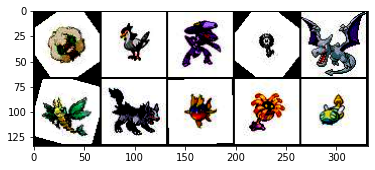

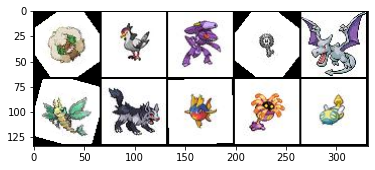

In [23]:
pkmn_dataloader = pkmn_dataloader_train

test_img_size = 10

# show a batch before and after denorm
test_data_iter = iter(pkmn_dataloader)
test_images, test_labels = next(test_data_iter)

print("length of dataset (number of steps) is: {}, total size is: {}".format(len(pkmn_dataloader), len(pkmn_dataloader)*batch_size))


if show_preview:
  show_tensor_images(test_images[0:test_img_size], num_images = test_size, size = (3,64,64), denorm_transform = None)
  show_tensor_images(test_images[0:test_img_size], num_images = test_size, size = (3,64,64), denorm_transform = denorm_transform)

In [25]:
# Create the generator/discriminator and use them
# layer initialization for Generator and Discriminator (for Conv2d and ConvTranpose2d)

model = MultiClassConvNetStandardDropout(num_classes = num_classes, hidden_dim = hidden_dim).to(device) 
model_opt = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta_1, beta_2))

print("Initializing the model with {} classes!".format(num_classes))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
model = model.apply(weights_init)

# summarize the model and its parameters
summary(model, [(3,64,64)])

Initializing the model with 13 classes!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           1,568
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
         Dropout2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          32,832
       BatchNorm2d-6           [-1, 64, 16, 16]             128
         LeakyReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8            [-1, 128, 8, 8]         131,200
       BatchNorm2d-9            [-1, 128, 8, 8]             256
        LeakyReLU-10            [-1, 128, 8, 8]               0
        Dropout2d-11            [-1, 128, 8, 8]               0
           Conv2d-12            [-1, 256, 4, 4]         524,544
      BatchNorm2d-13            [-1, 256, 4, 4]             512

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/93 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/93 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Step 100: Epoch: 1: loss: 1.2103900909423828 acc: 0.61328125


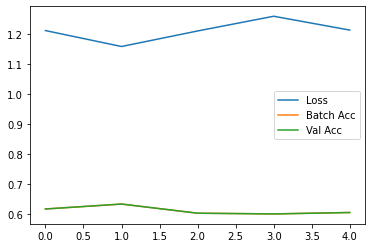

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/24 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Latest validation accuracy after 1 epochs is: 0.5520974289580515


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa148261440>
Traceback (most recent call last):
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    [W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/93 [00:00<?, ?it/s]

if w.is_alive():
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Step 200: Epoch: 2: loss: 1.0968127250671387 acc: 0.648375


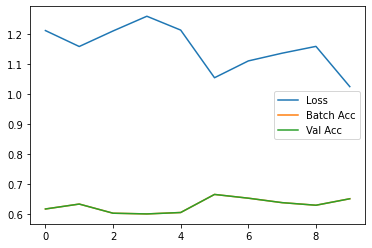

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/24 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Latest validation accuracy after 2 epochs is: 0.574424898511502


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa148261440>
Traceback (most recent call last):
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    [W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/93 [00:00<?, ?it/s]

if w.is_alive():
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Step 300: Epoch: 3: loss: 1.0145608186721802 acc: 0.67559375


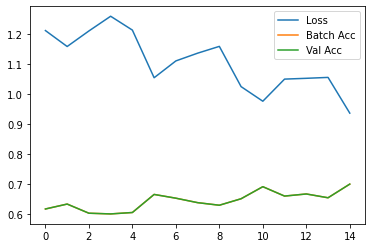

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/24 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Latest validation accuracy after 3 epochs is: 0.5886332882273342


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa148261440>
Traceback (most recent call last):
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/93 [00:00<?, ?it/s]

  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Step 400: Epoch: 4: loss: 0.9705817699432373 acc: 0.69125


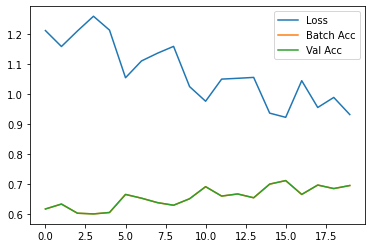

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/24 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Latest validation accuracy after 4 epochs is: 0.6123139377537212


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa148261440>
Traceback (most recent call last):
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
      File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/93 [00:00<?, ?it/s]

    if w.is_alive():
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Step 500: Epoch: 5: loss: 0.8830840587615967 acc: 0.7195625


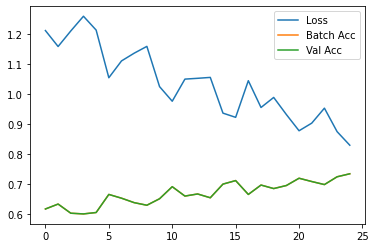

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/24 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Latest validation accuracy after 5 epochs is: 0.6048714479025711


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa148261440>
Traceback (most recent call last):
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/93 [00:00<?, ?it/s]


    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Step 600: Epoch: 6: loss: 0.8354676961898804 acc: 0.73103125


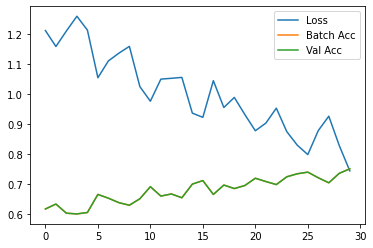

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/24 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Latest validation accuracy after 6 epochs is: 0.6359945872801083


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa148261440>
Traceback (most recent call last):
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
      File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
if w.is_alive():
    [W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/93 [00:00<?, ?it/s]

assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Step 700: Epoch: 7: loss: 0.7789025902748108 acc: 0.7528437499999999


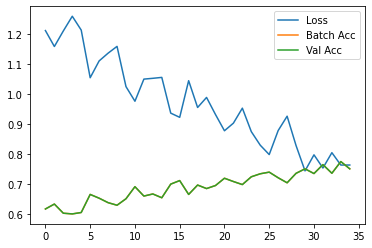

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/24 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Latest validation accuracy after 7 epochs is: 0.628552097428958


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa148261440>
Traceback (most recent call last):
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers

    if w.is_alive():  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/93 [00:00<?, ?it/s]

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Step 800: Epoch: 8: loss: 0.7240397930145264 acc: 0.77278125


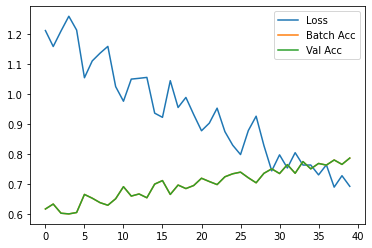

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/24 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa148261440>
Traceback (most recent call last):
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa148261440>
Traceba

Latest validation accuracy after 8 epochs is: 0.6583220568335588


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa148261440>
Traceback (most recent call last):
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    [W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
self._shutdown_workers()
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa148261440>
Traceba

    self._shutdown_workers()
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


  0%|          | 0/93 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Step 900: Epoch: 9: loss: 0.6736840009689331 acc: 0.7919687500000001


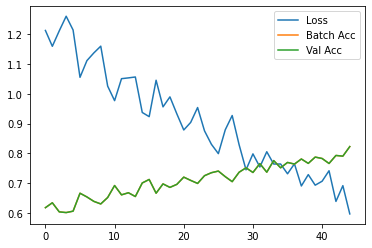

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/24 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Latest validation accuracy after 9 epochs is: 0.645466847090663


In [35]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

cur_step = 0
losses = []
batch_accs = []
val_accs = []

for epoch in range(n_epochs):
    # Dataloader returns the (real_images, labels)
    for real, true_labels in tqdm(pkmn_dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        true_labels = true_labels.to(device)
        
        # zero out optimizer
        model_opt.zero_grad()
        
        # get the predictions. Shape (bs, num_classes)
        model_logits = model(real)
                
        model_preds = torch.argmax(model_logits, dim = 1)
        
        # y_true, y_pred
        model_acc = accuracy_score(true_labels, model_preds)
        batch_accs.append(model_acc)
        
        # compute the loss on a batch
        ce_loss = loss_func(model_logits, true_labels)
        
        # record loss for graphing purposes
        losses.append(ce_loss)
        
        # backprop
        ce_loss.backward()
        
        # update optimizer
        model_opt.step()
        
        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            mean_loss = sum(losses[-display_step:]) / display_step
            mean_acc = sum(batch_accs[-display_step:]) / display_step
            print(f"Step {cur_step}: Epoch: {epoch}: loss: {mean_loss} acc: {mean_acc}")
            step_bins = 20
            
            num_examples = (len(losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(batch_accs[:num_examples]).view(-1, step_bins).mean(1),
                label="Val Acc"
            )                   
            plt.legend()
            plt.show()
            
            val_acc = compute_validation_accuracy(model, pkmn_dataloader_val)
            val_accs.append(val_acc)
            
            print("Latest validation accuracy after {} epochs is: {}".format(epoch, val_acc))
        
        # increase the current step (ie. one batch)
        cur_step += 1
        
    if periodic_saving and epoch % epoch_save_step == 0:
      outfile_name = "{}_{}.pt".format(save_prefix, cur_step)
      print("===== Saving intermediate model with name {} ! ====".format(outfile_name))
      save_model(gen, outfile_name)

In [37]:
# Save the final model

out_file = "mutliclass_dcgan_prediction.pt"
  
save_model(model, out_file)